In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from  torch.distributions.multivariate_normal import MultivariateNormal
from torch.optim import lr_scheduler
from tqdm import tqdm
from IPython import display

import torchvision.utils as vutils
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from torchvision.transforms import ToPILImage


import os
from os import listdir
from pathlib import Path
import imghdr
import skillsnetwork

In [2]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def plot_distribution(real_data,generated_data,discriminator=None,density=True):
    
    plt.hist(real_data.numpy(), 100, density=density, facecolor='g', alpha=0.75, label='real data')
    plt.hist(generated_data.numpy(), 100, density=density, facecolor='r', alpha=0.75,label='generated data q(z) ')
    
    if discriminator:
        max_=torch.max(real_data.max(),generated_data.max().detach())
        min_=torch.min(real_data.min(),generated_data.min().detach())
        x=torch.linspace(start=min_, end=max_, steps=100)
        plt.plot(x.numpy(),discriminator(x.view(-1,1)).detach().view(-1).numpy(),label='discriminator',color='k')
        plt.plot(x.numpy(),0.5*np.ones(x.shape),label='0.5',color='b')
        plt.legend()
        plt.show()

In [3]:
# plot batch of images
def plot_image_batch(my_batch):

  fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))
  img_num=0
  for i in range(8):
      for j in range(8):
          ax = axes[i][j]
          img_num+=1
  
          ax.imshow(np.transpose(vutils.make_grid(my_batch[img_num].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
  plt.show()

In [6]:
def get_accuracy(X,Xhat):
    total=0
    py_x=D(X)
    total=py_x.mean()
    py_x=D(Xhat)
    total+=py_x.mean()
    return total/2

In [7]:
class Dataset(Dataset):
    def __init__(self, covariance_matrix, mean,n_samples=1000):
        self.obj =  MultivariateNormal(loc=mean, covariance_matrix=covariance_matrix)
        self.mean=mean
        self.covariance_matrix=covariance_matrix
        self.X=torch.tensor([[self.obj.sample()] for n in range(n_samples)])
        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        
        return self.X[idx,:]

In [8]:
n_samples=10000
mean=10*torch.ones(1)
covariance_matrix=0.1*torch.eye(1)

dataset=Dataset(covariance_matrix=covariance_matrix, mean=mean,n_samples=n_samples)

In [9]:
Z=torch.randn(n_samples,1)

In [10]:
print("mean:",Z.mean())
print("standard deviation:",Z.std())

mean: tensor(0.0078)
standard deviation: tensor(1.0008)


In [11]:
Z=torch.randn(n_samples,1)

In [12]:
print("mean:",Z.mean())
print("standard deviation:",Z.std())

mean: tensor(-0.0020)
standard deviation: tensor(0.9952)


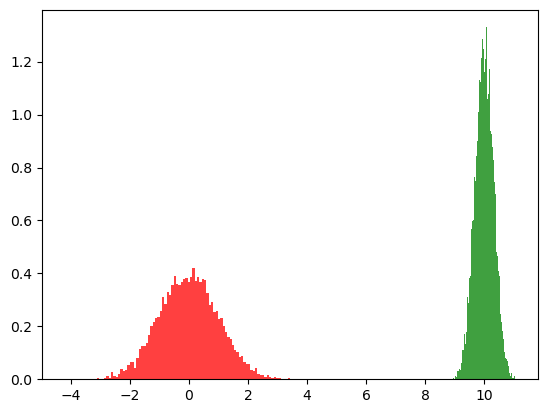

In [13]:
plot_distribution(real_data=dataset.X,generated_data=Z)

In [14]:
Xhat=Z+10

In [15]:
print("mean:",Xhat.mean())
print("standard deviation:",Xhat.std())

mean: tensor(9.9980)
standard deviation: tensor(0.9952)


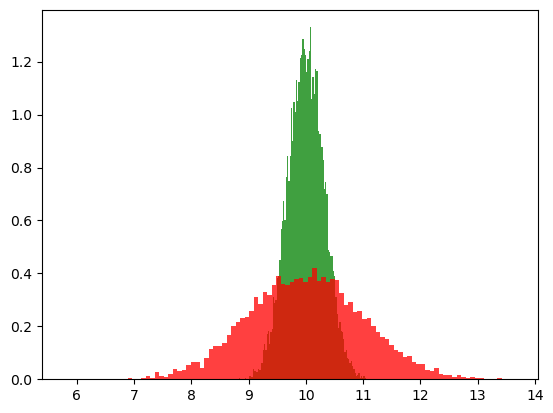

In [16]:
plot_distribution(real_data=dataset.X,generated_data=Xhat)

In [17]:
class Generator(nn.Module):
    def __init__(self,input_dim=1):
        super(Generator,self).__init__()
        self.l1=nn.Linear(1,input_dim)
    
    def forward(self, x):
        return self.l1(x)
G=Generator()

In [18]:
class Discriminator(nn.Module):
    def __init__(self,input_dim=1):
        super(Discriminator,self).__init__()
        self.l1=nn.Linear(1,input_dim)
    
    def forward(self, x):
        return torch.sigmoid(self.l1(x))

D=Discriminator() 

In [19]:
D

Discriminator(
  (l1): Linear(in_features=1, out_features=1, bias=True)
)

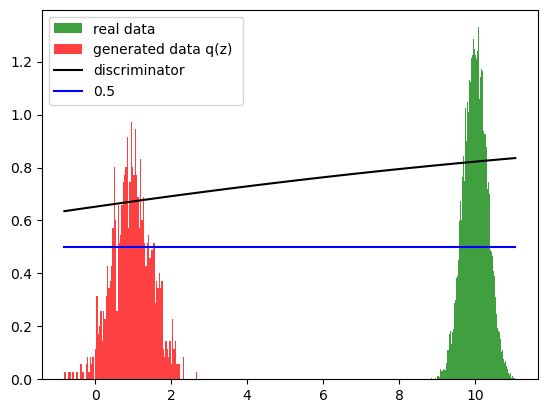

In [20]:
n_samples=1000
Xhat=G(torch.randn(n_samples,1))
plot_distribution(real_data=dataset.X,generated_data=Xhat.detach(),discriminator=D)

In [21]:
py_x=D(dataset.X)
torch.sum(py_x>0.5)/len(py_x)

tensor(1.)

In [22]:
py_x=D(Z)
torch.sum(py_x>0.5)/len(py_x)

tensor(1.)

In [23]:
Z

tensor([[ 0.7874],
        [-0.1553],
        [ 0.5629],
        ...,
        [-0.5422],
        [-0.2777],
        [-0.9009]])

In [24]:
get_accuracy(dataset.X,Xhat)

tensor(0.7468, grad_fn=<DivBackward0>)

In [25]:
criterion=nn.BCELoss()

In [26]:
criterion(D(G(Z)),torch.zeros(Z.shape[0],1))

tensor(1.1144, grad_fn=<BinaryCrossEntropyBackward0>)

In [27]:
criterion(D(dataset.X),torch.ones(len(dataset),1))+criterion(D(G(Z)),torch.zeros(Z.shape[0],1))/2

tensor(0.7531, grad_fn=<AddBackward0>)

In [28]:
# Learning rate for optimizers
lr = 0.1

# Beta1 hyperparam for Adam optimizers
beta1 = 0.1

G=Generator()
D=Discriminator()

optimizerG=optim.Adam(G.parameters(),lr=lr,betas=(beta1, 0.999))
optimizerD=optim.Adam(D.parameters(),lr=lr,betas=(beta1, 0.999))

In [29]:
batch_size=100

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

  0%|          | 0/20 [00:00<?, ?it/s]

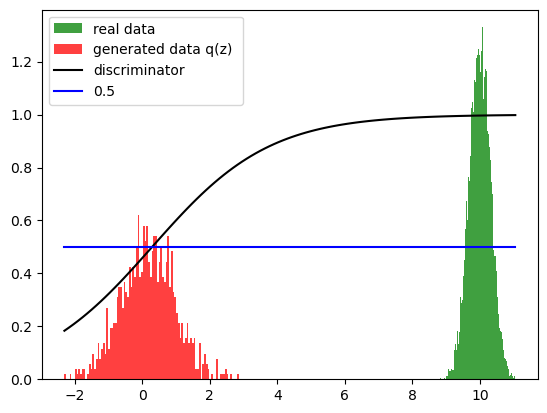

  5%|▌         | 1/20 [00:00<00:14,  1.34it/s]

Epoch: 0


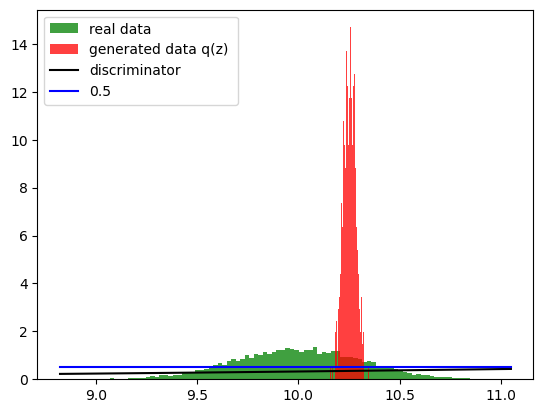

 10%|█         | 2/20 [00:01<00:12,  1.39it/s]

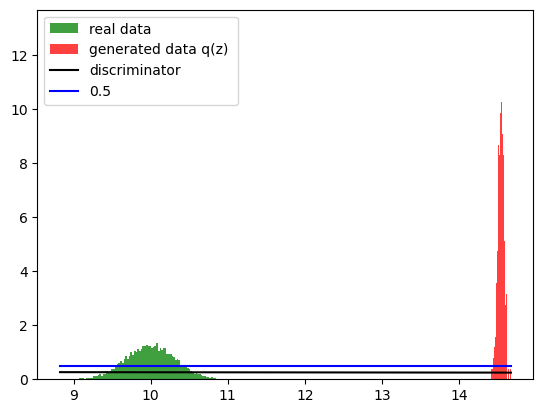

 15%|█▌        | 3/20 [00:02<00:11,  1.43it/s]

Epoch: 2


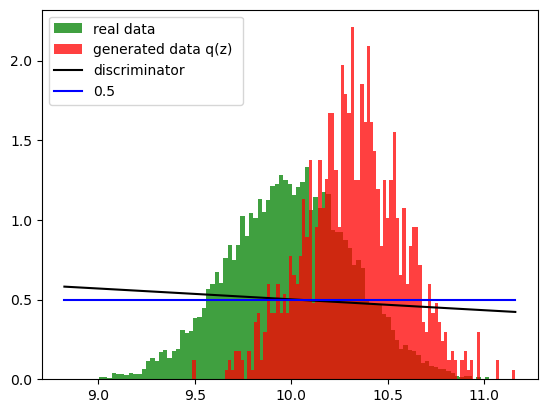

 20%|██        | 4/20 [00:02<00:10,  1.56it/s]

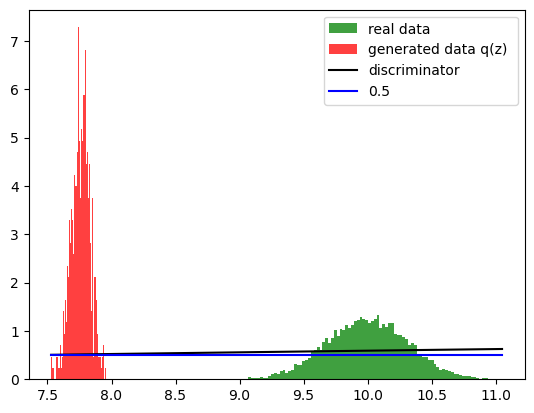

 25%|██▌       | 5/20 [00:03<00:09,  1.59it/s]

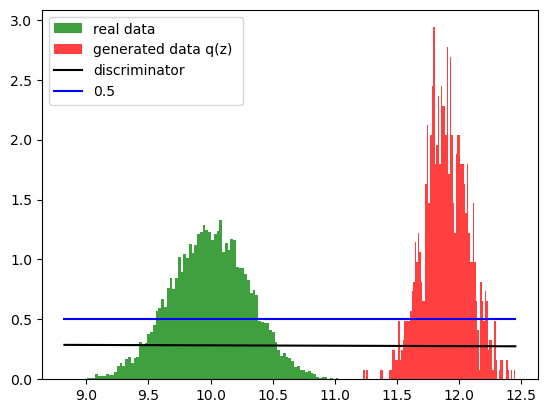

 30%|███       | 6/20 [00:03<00:09,  1.52it/s]

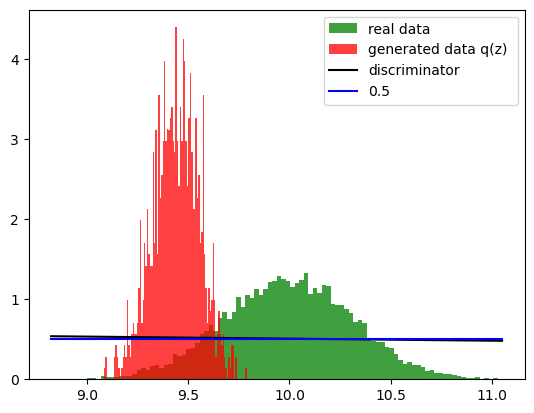

 35%|███▌      | 7/20 [00:04<00:09,  1.44it/s]

Epoch: 6


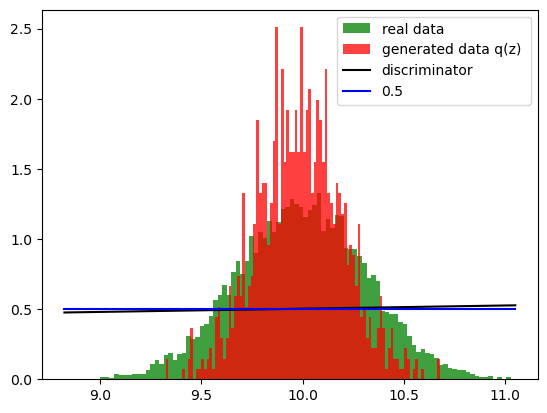

 40%|████      | 8/20 [00:05<00:07,  1.57it/s]

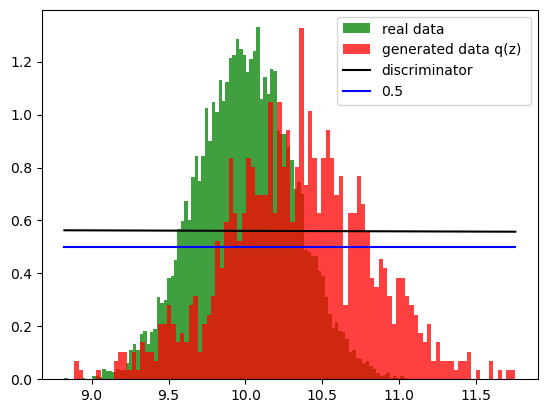

 45%|████▌     | 9/20 [00:05<00:06,  1.57it/s]

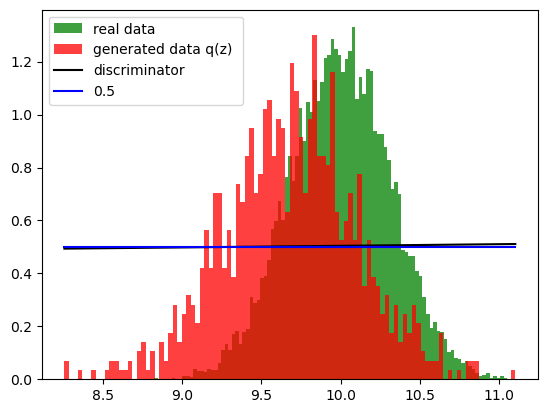

 50%|█████     | 10/20 [00:06<00:06,  1.57it/s]

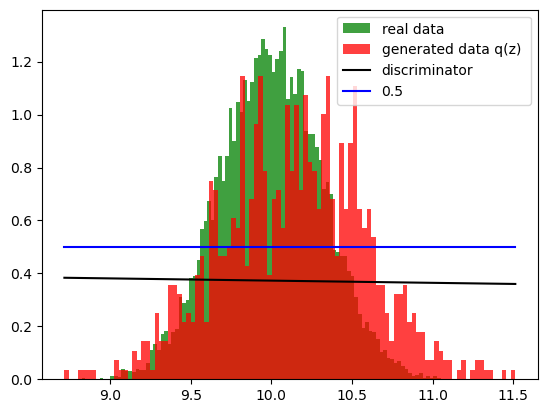

 55%|█████▌    | 11/20 [00:07<00:05,  1.64it/s]

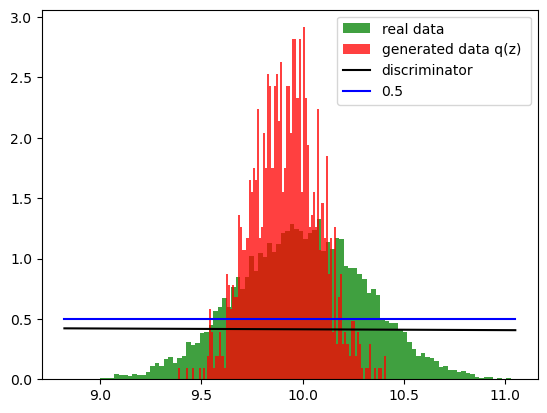

 60%|██████    | 12/20 [00:07<00:04,  1.71it/s]

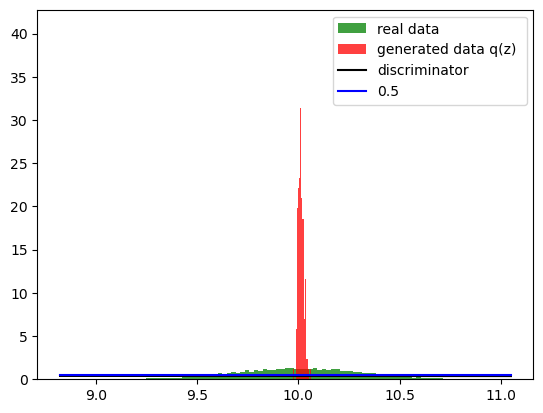

 65%|██████▌   | 13/20 [00:08<00:03,  1.76it/s]

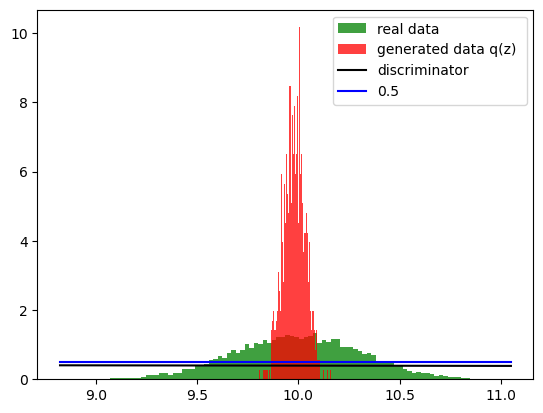

 70%|███████   | 14/20 [00:08<00:03,  1.69it/s]

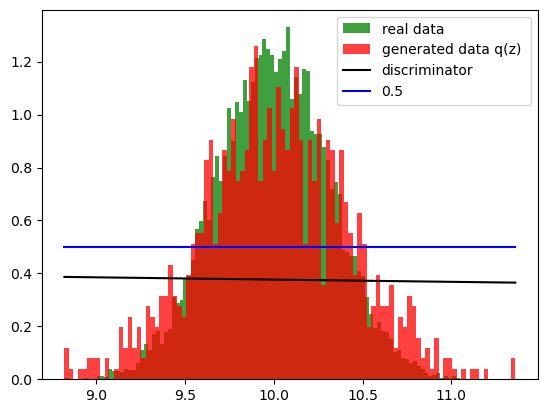

 75%|███████▌  | 15/20 [00:09<00:02,  1.72it/s]

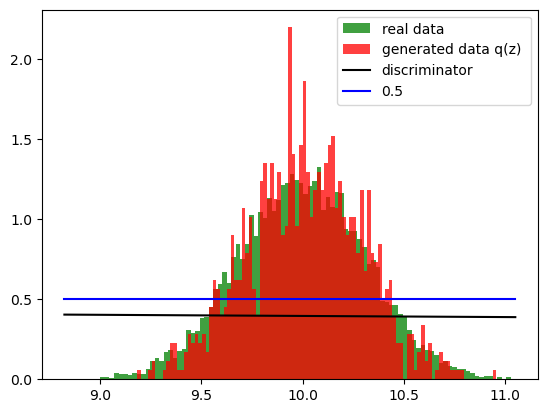

 80%|████████  | 16/20 [00:10<00:02,  1.62it/s]

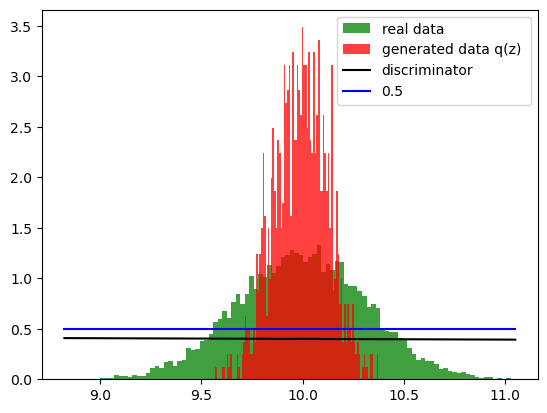

 85%|████████▌ | 17/20 [00:10<00:01,  1.62it/s]

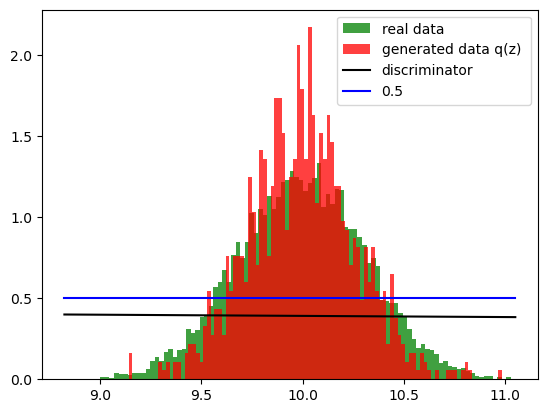

 90%|█████████ | 18/20 [00:11<00:01,  1.60it/s]

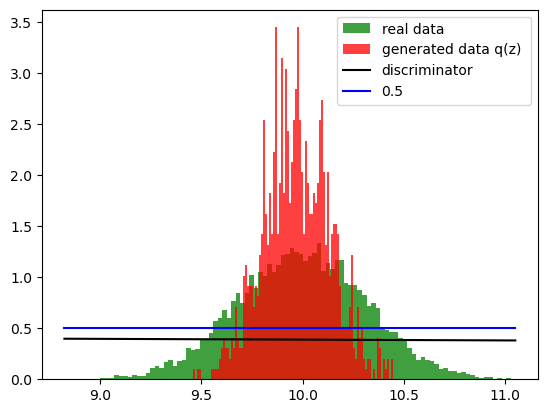

 95%|█████████▌| 19/20 [00:11<00:00,  1.68it/s]

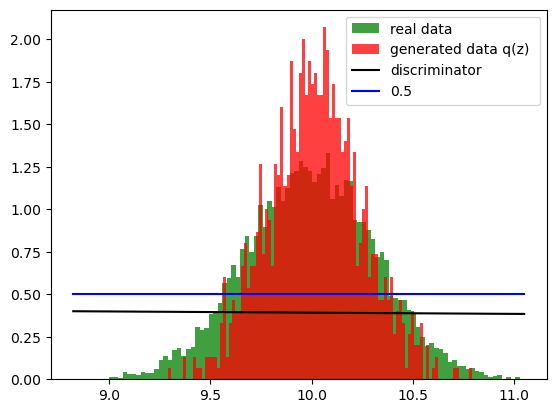

100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


In [30]:
LOSS_G=[]
LOSS_D=[]

epochs=20

noise_dim=1
epsilon=100 

# Training loop
for epoch in tqdm(range(epochs)):
    # Plot the data distribution and generated samples
    Xhat=G(torch.randn(n_samples,1))
    plot_distribution(real_data=dataset.X, generated_data=Xhat.detach(), discriminator=D)
    
    # Training the discriminator
    for real_data in dataloader:
        noise = torch.randn(batch_size, 1)
        fake_data = G(noise)
        
        # Discriminator predictions for real and fake data
        real_predictions = D(real_data)
        fake_predictions = D(fake_data)
 
        # Discriminator loss for real and fake data
        loss_D_real = criterion(real_predictions, torch.ones(batch_size, 1))
        loss_D_fake = criterion(fake_predictions, torch.zeros(batch_size, 1))
        
        # Overall discriminator loss
        loss_D = (loss_D_fake + loss_D_real) / 2
        LOSS_D.append(loss_D.detach().item())
        
        # Backpropagation and optimizer update for discriminator
        D.zero_grad()
        loss_D.backward(retain_graph=True)
        optimizerD.step()
        
        # Training the generator
        output = D(fake_data)
        loss_G = criterion(output, torch.ones(batch_size, 1))
        LOSS_G.append(loss_G.detach().item())
    
        # Backpropagation and optimizer update for generator
        G.zero_grad()
        loss_G.backward()
        optimizerG.step()
    
    # Save and display the generator and discriminator if the performance increases 
    Xhat = G(torch.randn(len(dataset), 1))
    accuracy = abs(0.5 - get_accuracy(dataset.X, Xhat))
    if accuracy < epsilon:
        epsilon = accuracy
        torch.save(D.state_dict(), 'D.pth')
        torch.save(G.state_dict(), 'G.pth')
        print("Epoch:", epoch)

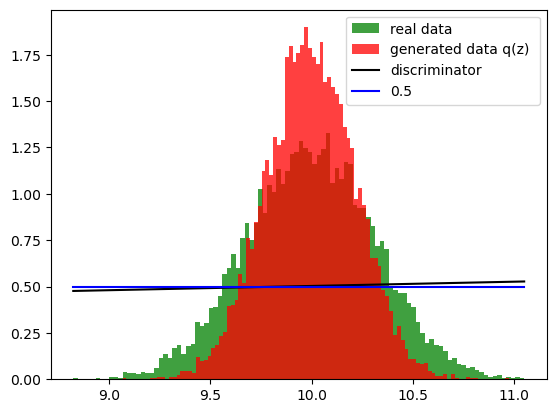

In [31]:
D=Discriminator()
D.load_state_dict(torch.load("D.pth"))
G=Generator()
G.load_state_dict(torch.load("G.pth"))

Xhat=G(torch.randn(len(dataset), 1))
plot_distribution(real_data=dataset.X, generated_data=Xhat.detach(), discriminator=D)

In [32]:
dataset_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/cartoon_20000.zip"
await skillsnetwork.prepare(dataset_url, overwrite=True)

  0%|          | 0/20001 [00:00<?, ?it/s]

Saved to '.'


In [33]:
img_height, img_width, batch_size=64,64,128

In [34]:
current_directory = os.getcwd()
directory=os.path.join(current_directory ,'cartoon_20000')
[filename for filename in os.listdir(directory) if filename.endswith('.jpg') ]

class Dataset(Dataset):
    def __init__(self, transform=None):
      current_directory = os.getcwd()
      directory=os.path.join(current_directory ,'cartoon_20000')

      self.file_paths = [os.path.join(directory,filename ) for filename in os.listdir(directory) if filename.endswith('.jpg') ]
      self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        image_path = self.file_paths[index]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image

In [35]:
dataset=Dataset()

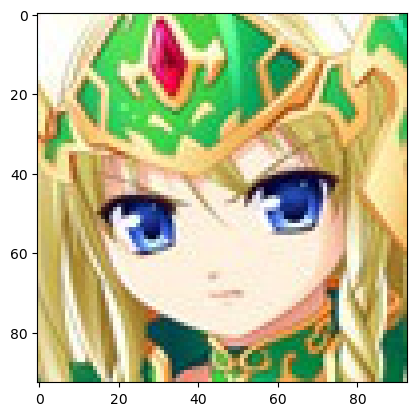

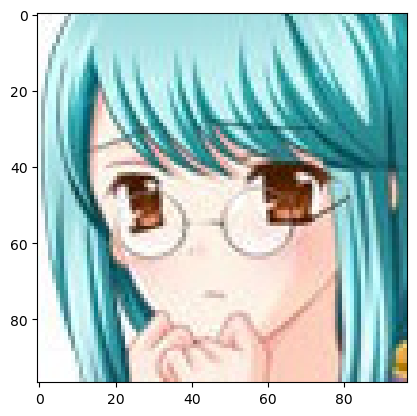

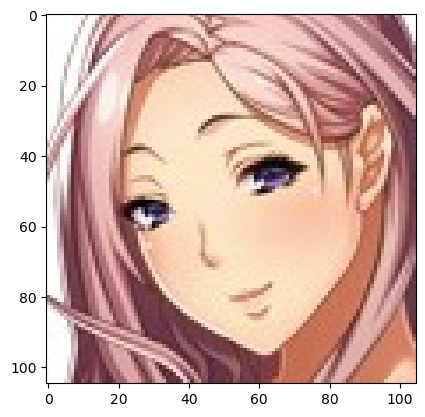

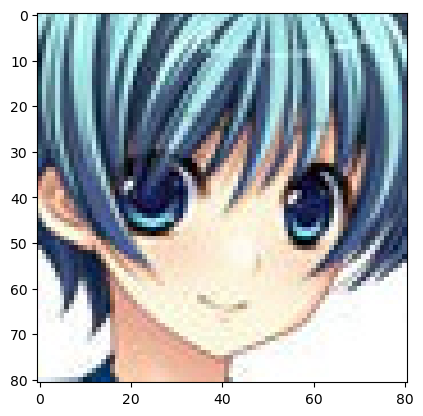

In [36]:
for i in range(1,5):
  plt.imshow(dataset[i])
  plt.show()

In [37]:
image_size = 64
transform=transforms.Compose([
                               transforms.Resize((64, 64)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [38]:
# Create the dataloader
# batch_size Batch size during training
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

In [39]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cpu')

In [40]:
real_batch = next(iter(dataloader))
real_batch.shape

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>

In [41]:
plot_image_batch(real_batch)

NameError: name 'real_batch' is not defined

In [42]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Block 1:input is Z, going into a convolution
            nn.ConvTranspose2d(latent_vector_size, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # Block 2: input is (64 * 8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # Block 3: input is (64 * 4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # Block 4: input is (64 * 2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Block 5: input is (64) x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: output is (3) x 64 x 64
        )
 
    def forward(self, input):
        output = self.main(input)
        return output    

In [43]:
latent_vector_size=128

G = Generator().to(device)
print(G)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [44]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Block 1: input is (3) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: input is (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: input is (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: input is (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: input is (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
        )
 
    def forward(self, input):
        output = self.main(input)
        return output

In [45]:
D =Discriminator().to(device)
print(D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
    (13): Flatten(start_dim=1, end_d

In [46]:
learning_rate = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5, 0.999))
scheduler_G = lr_scheduler.StepLR(G_optimizer, step_size=10, gamma=0.1)
scheduler_D = lr_scheduler.StepLR(D_optimizer, step_size=10, gamma=0.1)
device

device(type='cpu')

In [47]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias) 

D.apply(weights_init)
G.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

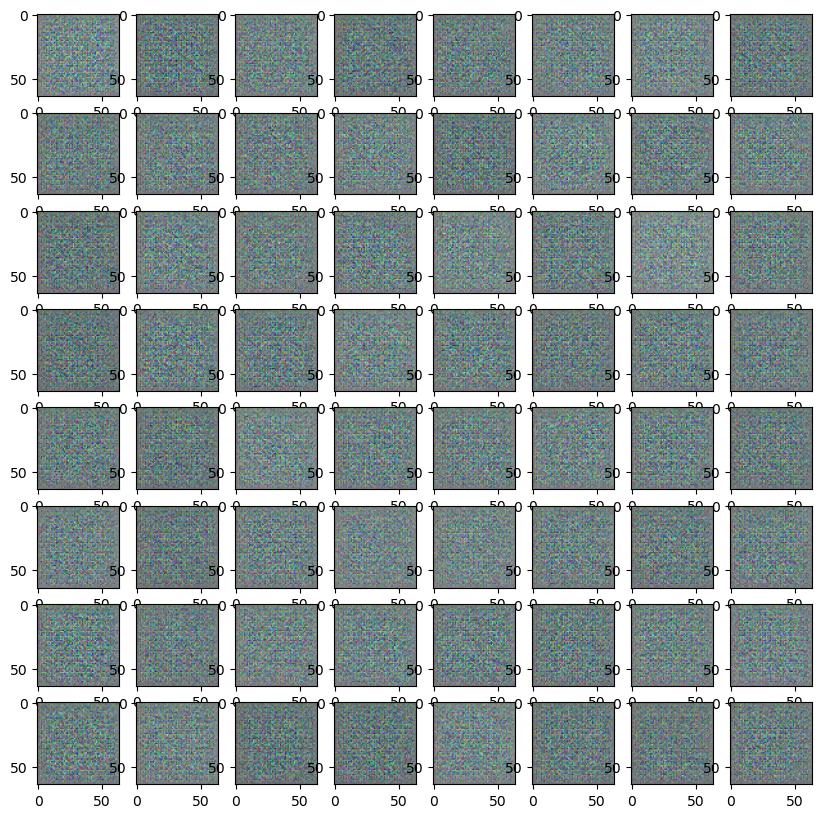

In [48]:
noise =  torch.randn(batch_size , latent_vector_size, 1, 1, device=device)
Xhat = G(noise).detach()
plot_image_batch(Xhat)

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
LOSS_G = []
LOSS_D = []
epochs = 1
epsilon = 100

# Training loop
for epoch in tqdm(range(epochs)):
    print(epoch)
    for real_data in dataloader:
        real_data = real_data.to(device)
        noise =torch.randn(batch_size  , latent_vector_size , 1, 1, device=device)
        fake_data = G(noise)
        
        # Discriminator predictions for real and fake data
        real_predictions = D(real_data)
        fake_predictions = D(fake_data)
 
        # Discriminator loss for real and fake data
        loss_D_real = criterion(real_predictions, torch.ones(len(real_predictions), 1).to(device))
        loss_D_fake = criterion(fake_predictions, torch.zeros(len(fake_predictions), 1).to(device))
        
        # Overall discriminator loss
        loss_D = (loss_D_fake + loss_D_real) / 2
        LOSS_D.append(loss_D.detach().item())
        
        # Backpropagation and optimizer update for discriminator
        D.zero_grad()
        loss_D.backward(retain_graph=True)
        D_optimizer.step()
        
        # Training the generator
        output = D(fake_data)
        loss_G = criterion(output, torch.ones(len(output), 1).to(device))
        LOSS_G.append(loss_G.detach().item())
    
        # Backpropagation and optimizer update for generator
        G.zero_grad()
        loss_G.backward()
        G_optimizer.step()
    
    # Using LR Scheduler
    scheduler_G.step()
    scheduler_D.step()
    
    # Displaying Images
    Xhat = G(noise).to(device).detach()
    plot_image_batch(Xhat)
    print("Epoch:", epoch)
    
    # Saving the model
    torch.save(D.state_dict(), 'D.pth')
    torch.save(G.state_dict(), 'G.pth')

  0%|          | 0/1 [00:00<?, ?it/s]

0


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>

In [50]:
D = Discriminator()
D.load_state_dict(torch.load("D_trained.pth", map_location=torch.device('cpu')))
G = Generator()
G.load_state_dict(torch.load("G_trained.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

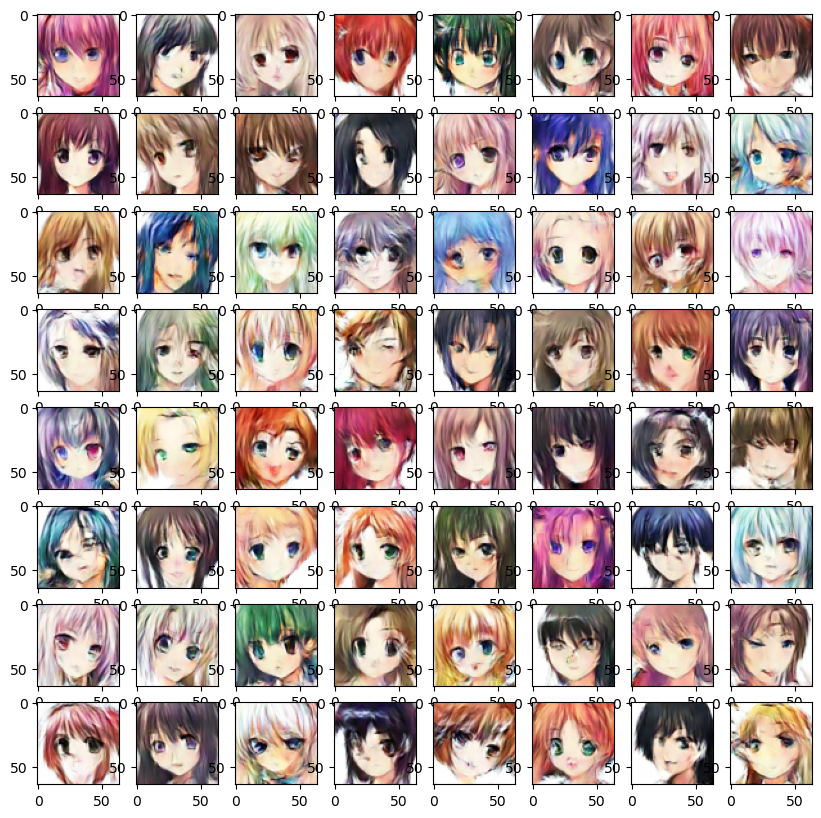

In [51]:
latent_vector_size=128
z =  torch.randn(batch_size  , latent_vector_size , 1, 1)

Xhat=G(z).detach()
plot_image_batch(Xhat)

the value of c is  1


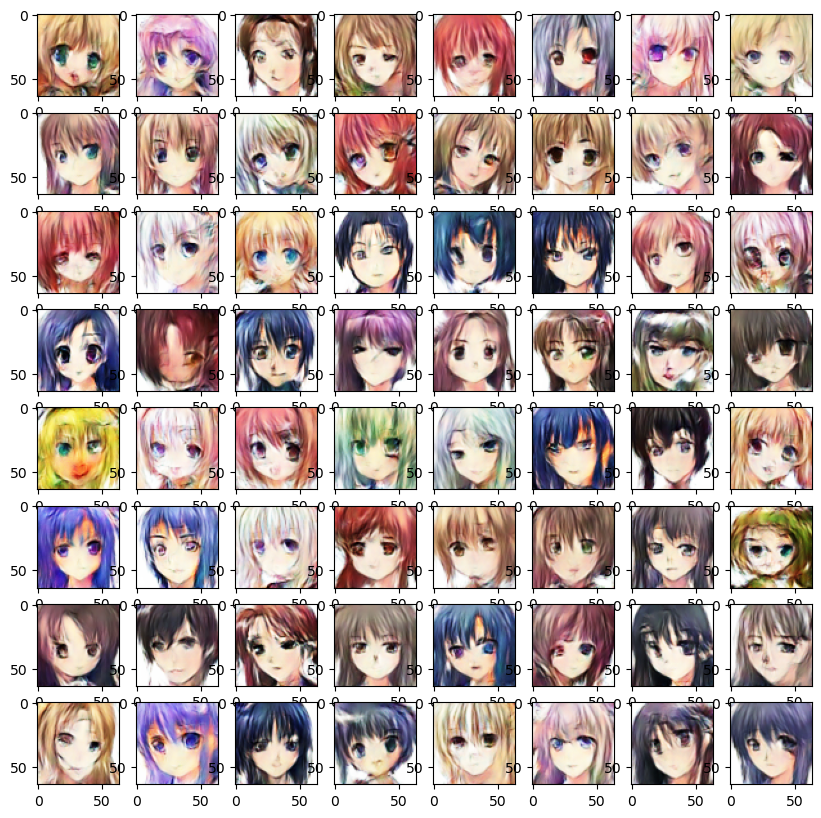

the value of c is  0.8


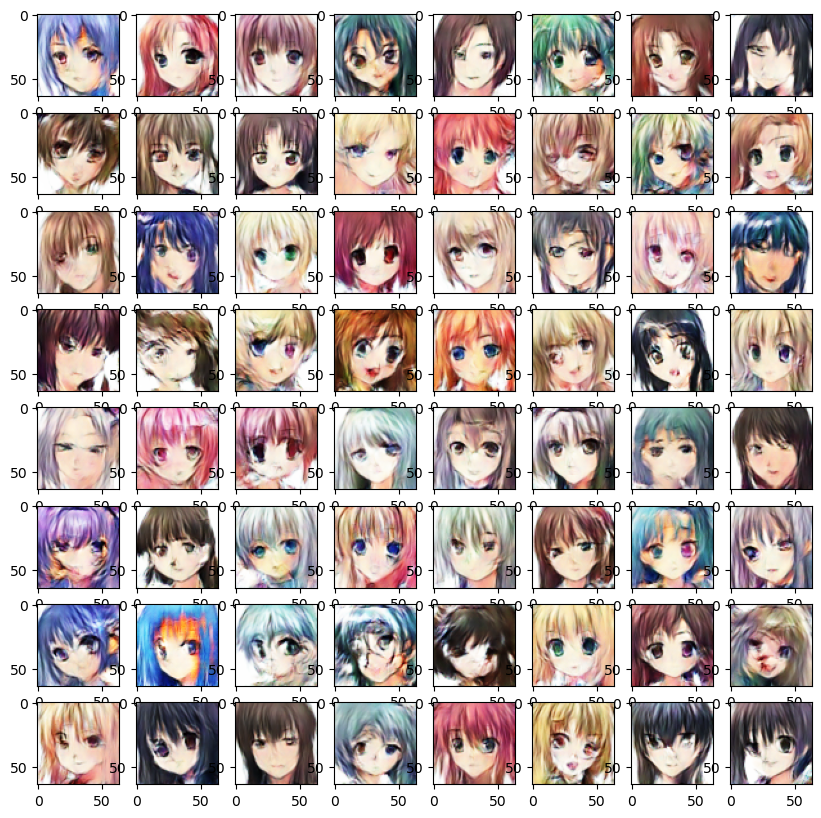

the value of c is  0.6


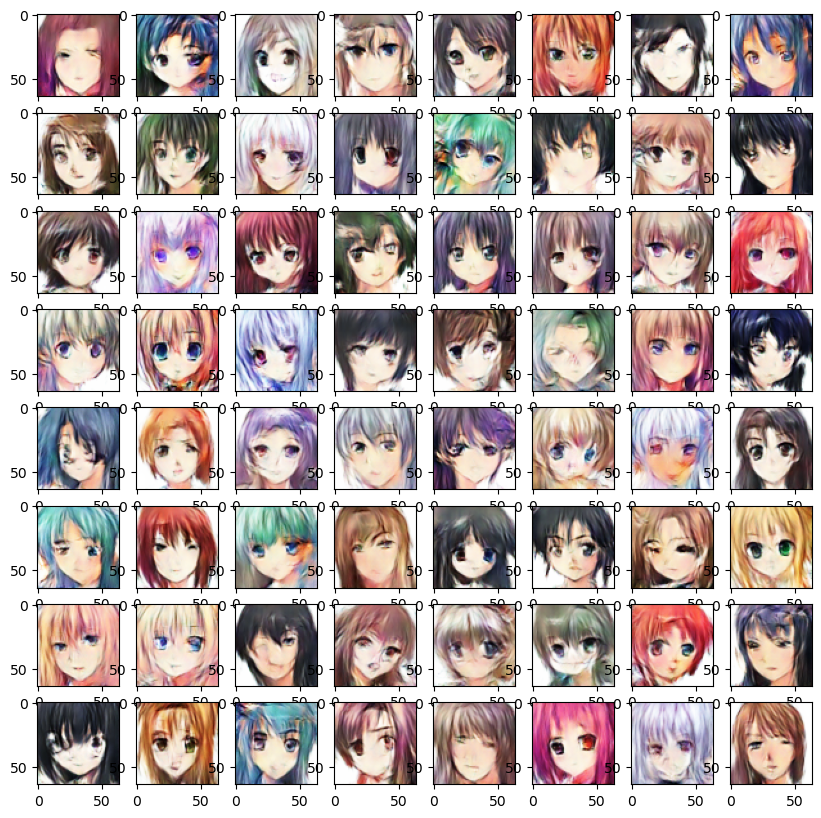

the value of c is  0.4


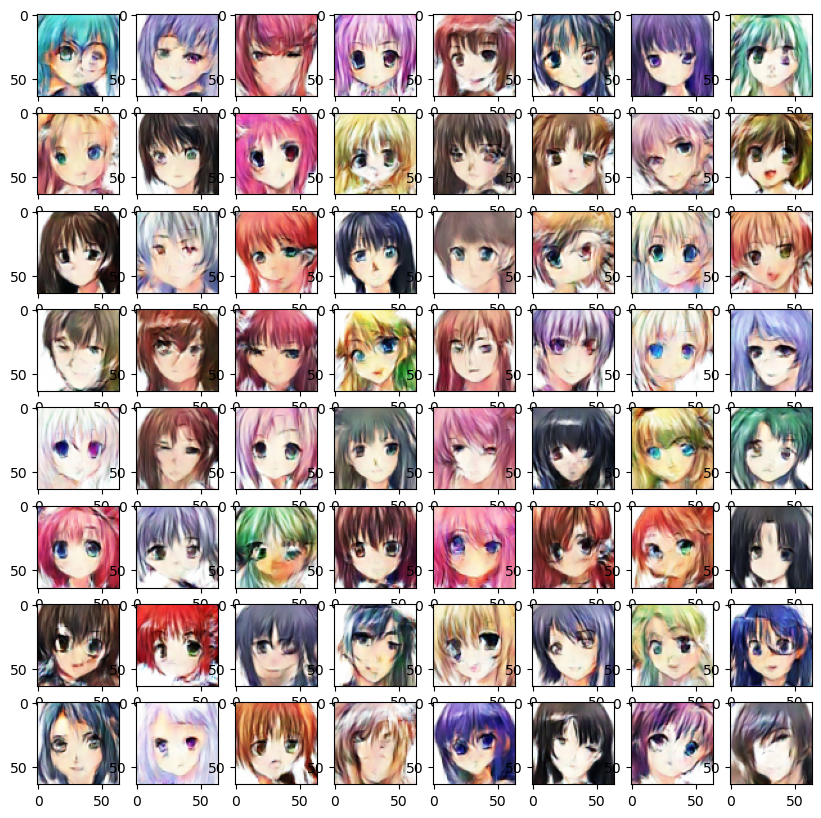

In [52]:
# Write your code here
for c in [1,0.8,0.6,0.4]:
    z =  torch.randn(batch_size, latent_vector_size, 1, 1)
    print("the value of c is ", c)

    Xhat=G(c*z).detach()
    plot_image_batch(Xhat)

elements from 0 to 0 is set to -1


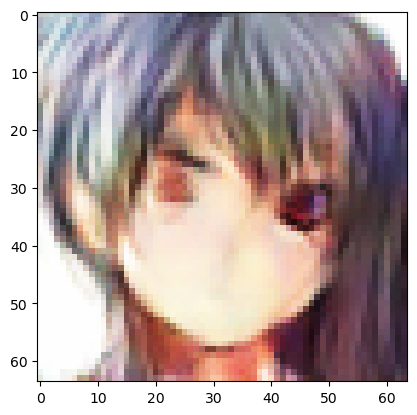

elements from 0 to 10 is set to -1


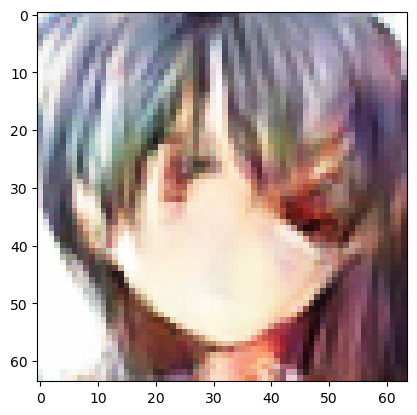

elements from 0 to 20 is set to -1


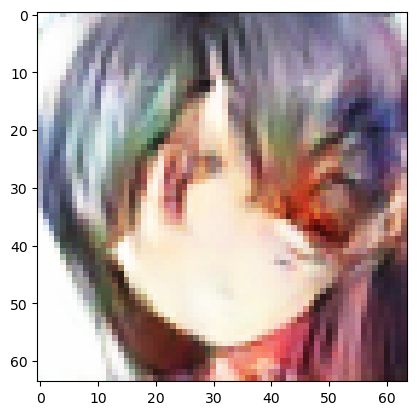

elements from 0 to 30 is set to -1


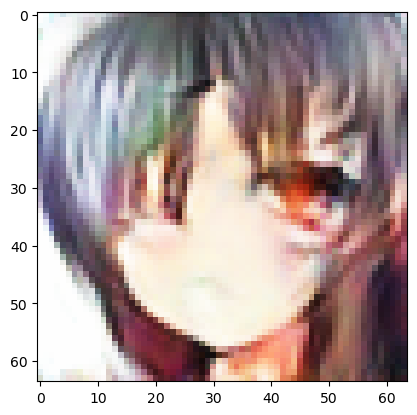

elements from 0 to 40 is set to -1


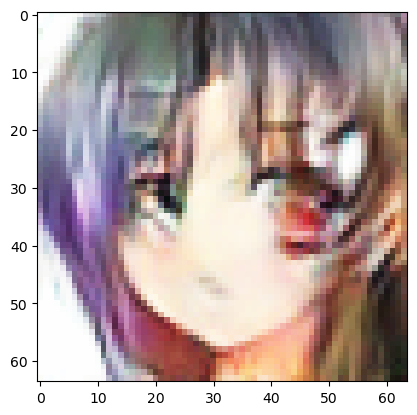

In [53]:
# Write your code here
seed_value = 42

# Set the seed for generating random numbers
torch.manual_seed(seed_value)

# Generate a random noise vector 'z'
z = torch.randn(1, latent_vector_size, 1, 1)

# Create an instance of the 'ToPILImage' class
to_pil_image = ToPILImage()

for n in range(5):
    
    # Modify elements of 'z'
    z[0, 0:10*n, 0, 0]= -0.5*n
        
    # Generate an image with the modified 'z'
    Xhat=G(z).detach().squeeze(0)
    
    # Normalize the generated image
    Xhat = (Xhat + 1) / 2

    print("elements from 0 to {} is set to -1".format(10*n))
    plt.imshow(to_pil_image(Xhat))
    plt.show()

elements from 0 to 0 is set to -1


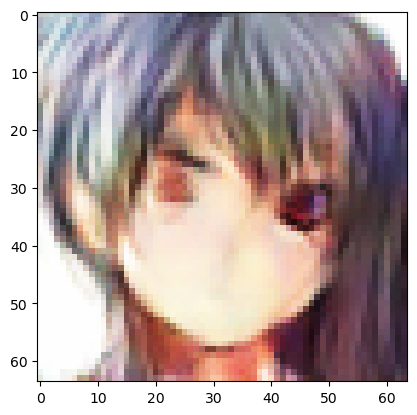

elements from 0 to 10 is set to -1


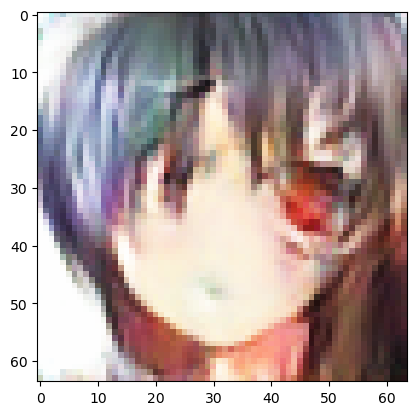

elements from 0 to 20 is set to -1


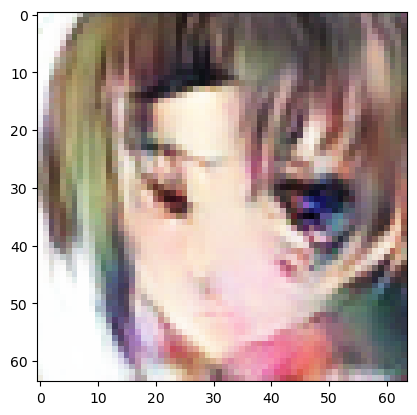

elements from 0 to 30 is set to -1


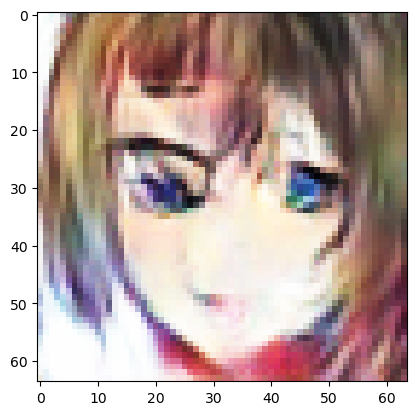

elements from 0 to 40 is set to -1


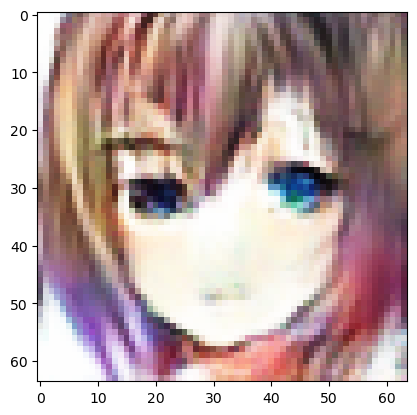

In [54]:
# Write your code here
# Set the desired seed value
seed_value = 42

# Set the seed for generating random numbers
torch.manual_seed(seed_value)

# Generate a random noise vector 'z'
z = torch.randn(1, latent_vector_size, 1, 1)

# Create an instance of the 'ToPILImage' class
to_pil_image = ToPILImage()
for n in range(5):
    
    # Modify elements of 'z'
    z[0, 0:35*n, 0, 0]= -1
    
    # Generate an image with the modified 'z'
    Xhat=G(z).detach().squeeze(0)
    
    # Normalize the generated image
    Xhat = (Xhat + 1) / 2
    
    print("elements from 0 to {} is set to -1".format(10*n))
    plt.imshow(to_pil_image(Xhat))
    plt.show()